In [67]:
# Import Dependencies
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score 

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
# from pickle import dump
import sqlite3

In [68]:
# Call in the data
df = pd.read_csv('Resources/preprocessed.csv').drop(['Unnamed: 0'], axis=1)
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,_1,_5,9.99,7.99,1,0,245
1,_1,_1,_6,9.99,7.99,1,1,453
2,_1,_1,_7,9.99,7.99,1,0,409
3,_1,_1,_8,9.99,7.99,1,0,191
4,_1,_1,_9,9.99,9.99,0,0,145


## Migrating Data From Pythonto SQL

In [69]:
# # Set up connection
# conn=sqlite3.connect('Resources/db.sqlite')

In [70]:
# Convert Pandas DataFrame to SQL Database
# df.to_sql('profitPredictor_db', conn, if_exists='replace', index=False)

In [71]:
# #  Confirm data is in SQL database. 
# pd.read_sql('select * from profitPredictor_db', conn)

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,_1,_5,9.99,7.99,1,0,245
1,_1,_1,_6,9.99,7.99,1,1,453
2,_1,_1,_7,9.99,7.99,1,0,409
3,_1,_1,_8,9.99,7.99,1,0,191
4,_1,_1,_9,9.99,9.99,0,0,145
...,...,...,...,...,...,...,...,...
3856,_10,_3,_39,19.99,19.99,0,0,133
3857,_10,_3,_40,19.99,19.99,0,0,133
3858,_10,_3,_41,19.99,19.99,0,0,127
3859,_10,_3,_42,19.99,19.99,0,0,133


In [72]:
# Assign product variables
pro1=df[df['Product']=='_1']
pro2=df[df['Product']=='_2']
pro3=df[df['Product']=='_3']    

In [73]:
# Create features
X=df.drop(columns=['Weekly_Units_Sold'], axis = 1)

X=pd.get_dummies(X)

# Create target. 
y = df['Weekly_Units_Sold']

## Gradient Boosting Regression

In [74]:
model=GradientBoostingRegressor()
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculating Cross Validation Score across multiple testing sets
scores = cross_val_score(model, X_train_scaled, y_train, cv=20)
scores
print("Cross Validation Score: %0.3f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))


model.fit(X_train_scaled, y_train)
pred=model.predict(X_test_scaled)

# for classification we use accuracy and F1 score
print("Training Accuracy: %.3f" % model.score(X_train_scaled,y_train))
print("Testing Accuracy: %.3f" % model.score(X_test_scaled, y_test))


# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above

print("Mean Absolute Error: %.3f" % mean_absolute_error(y_test,pred))
print("R2 Score: %.3f" % r2_score(y_test,pred))

Cross Validation Score: 0.880 accuracy with a standard deviation of 0.068
Training Accuracy: 0.904
Testing Accuracy: 0.814
Mean Absolute Error: 43.331
R2 Score: 0.814


## Feature Importance on the Model

Text(0, 0.5, 'Feature Importance Score')

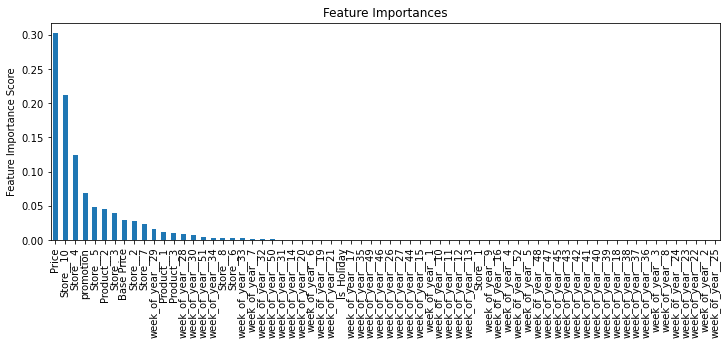

In [75]:
feat_imp = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [76]:
cross_val_score(model, X_train_scaled, y_train, cv=10)

array([0.89406359, 0.93226116, 0.89242747, 0.83312848, 0.88488664,
       0.90102304, 0.86786623, 0.76095428, 0.82520686, 0.91867527])

In [77]:
(scores.mean(), scores.std())

(0.8800771738167823, 0.06780199893911215)

In [79]:
print(dir(GradientBoostingRegressor))
GradientBoostingRegressor()

['_SUPPORTED_LOSS', '__abstractmethods__', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_check_initialized', '_check_n_features', '_check_params', '_clear_state', '_compute_partial_dependence_recursion', '_estimator_type', '_fit_stage', '_fit_stages', '_get_param_names', '_get_tags', '_init_state', '_is_initialized', '_make_estimator', '_more_tags', '_raw_predict', '_raw_predict_init', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_required_parameters', '_resize_state', '_staged_raw_predict', '_validate_data',

GradientBoostingRegressor()

## Hypertuning the Model

In [108]:
GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.06, 0.065, 0.07, 0.075],
              'subsample'    : [0.095, 0.09, 0.085, 0.08],
              'n_estimators' : [850, 900, 950, 1000, 1050],
              'max_depth'    : [10, 11, 12, 13, 14, 15]
             }

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train_scaled, y_train)

# Generate predictions
y_pred = grid_GBR.predict(X_test_scaled)

# Generate r-squared
score = r2_score(y_test, y_pred)

print("Results from Grid Search")
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)
print("\n r-squared:\n",score)

Results from Grid Search

 The best score across ALL searched params:
 0.9157317839439093

 The best parameters across ALL searched params:
 {'learning_rate': 0.07, 'max_depth': 14, 'n_estimators': 900, 'subsample': 0.09}

 r-squared:
 0.91811617862771


## Final Hypertuned Model 

In [96]:
X_train

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
3550,10.99,8.79,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3016,9.99,7.99,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1057,5.99,5.99,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2730,5.99,5.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2466,19.99,19.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,9.99,9.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1344,10.99,10.99,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
527,10.99,10.99,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3197,5.99,5.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
params = {'learning_rate': 0.07,
          'subsample': 0.09,
          'n_estimators': 900,
          'max_depth': 14}
model = GradientBoostingRegressor(**params)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculating Cross Validation Score across multiple testing sets
scores = cross_val_score(model, X_train_scaled, y_train, cv=20)
scores
print("Cross Validation Score: %0.3f accuracy with a standard deviation of %0.3f" %
      (scores.mean(), scores.std()))


model.fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)

# for classification we use accuracy and F1 score
print("Training Accuracy: %.3f" % model.score(X_train_scaled, y_train))
print("Testing Accuracy: %.3f" % model.score(X_test_scaled, y_test))


# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above

print("Mean Absolute Error: %.3f" % mean_absolute_error(y_test, pred))
print("R2 Score: %.3f" % r2_score(y_test, pred))


Cross Validation Score: 0.934 accuracy with a standard deviation of 0.057
Training Accuracy: 0.991
Testing Accuracy: 0.928
Mean Absolute Error: 26.210
R2 Score: 0.928


In [116]:
X_test

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
2435,19.99,19.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2362,5.99,4.01,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
235,5.99,5.99,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2112,19.99,19.99,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1350,10.99,10.99,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,21.99,21.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2987,19.99,10.00,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3107,10.99,8.79,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
57,10.99,10.99,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
# X_test_scaled['Weekly_Units_Sold']= pred

pred_units=pd.Series(pred)
pred_units.describe()

count     966.000000
mean      206.962746
std       230.408212
min       -22.148681
25%        68.919929
50%       127.069347
75%       260.812163
max      2025.119470
dtype: float64

## Feature Importance on the Hypertuned Model

Text(0, 0.5, 'Feature Importance Score')

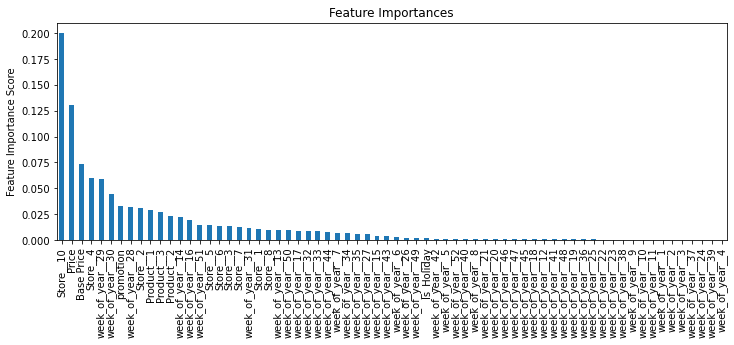

In [112]:
feat_imp = pd.Series(model.feature_importances_, X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

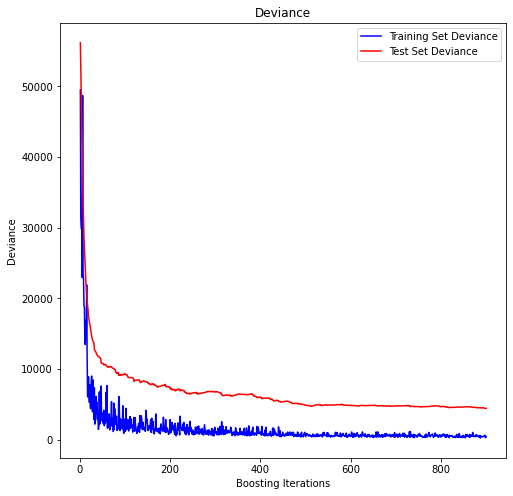

In [113]:
test_score = np.zeros(params['n_estimators'],)
for i, y_pred in enumerate(model.staged_predict(X_test_scaled)):
    test_score[i] = model.loss_(y_test, y_pred)
 
fig = plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, model.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
plt.show()

## Export Model

In [114]:
X_train

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
3550,10.99,8.79,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3016,9.99,7.99,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1057,5.99,5.99,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2730,5.99,5.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2466,19.99,19.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3441,9.99,9.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1344,10.99,10.99,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
527,10.99,10.99,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3197,5.99,5.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
# save the model
dump(model, 'Resources/model.joblib')
# save the scaler
dump(scaler, 'Resources/scaler.joblib')

['Resources/scaler.joblib']

In [89]:
# Load the model 
# model = load(open("Resources/model.pkl",'rb'))
# scaler = load(open("Resources/scaler.pkl", 'rb'))